# Day-ahead forecast

Download the file `Final.zip` from [this url](https://ieee-dataport.org/competitions/day-ahead-electricity-demand-forecasting-post-covid-paradigm#files) and extract the file `Actuals.xlsx` into `../outputs/`.

In [25]:
import jax
import numpy as np 
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from functools import partial
from matplotlib.gridspec import GridSpec
from bayes_opt import BayesianOptimization
from rebayes_mini.methods.gauss_filter import GaussianFilter, ExtendedKalmanFilter
from rebayes_mini.methods.adaptive import ExpfamRLPR, ExpfamEBA, ExpfamRLOUPR

In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## Download data

In [4]:
data = pd.read_excel("../outputs/Actuals.xlsx")
data = data.set_index("Time")

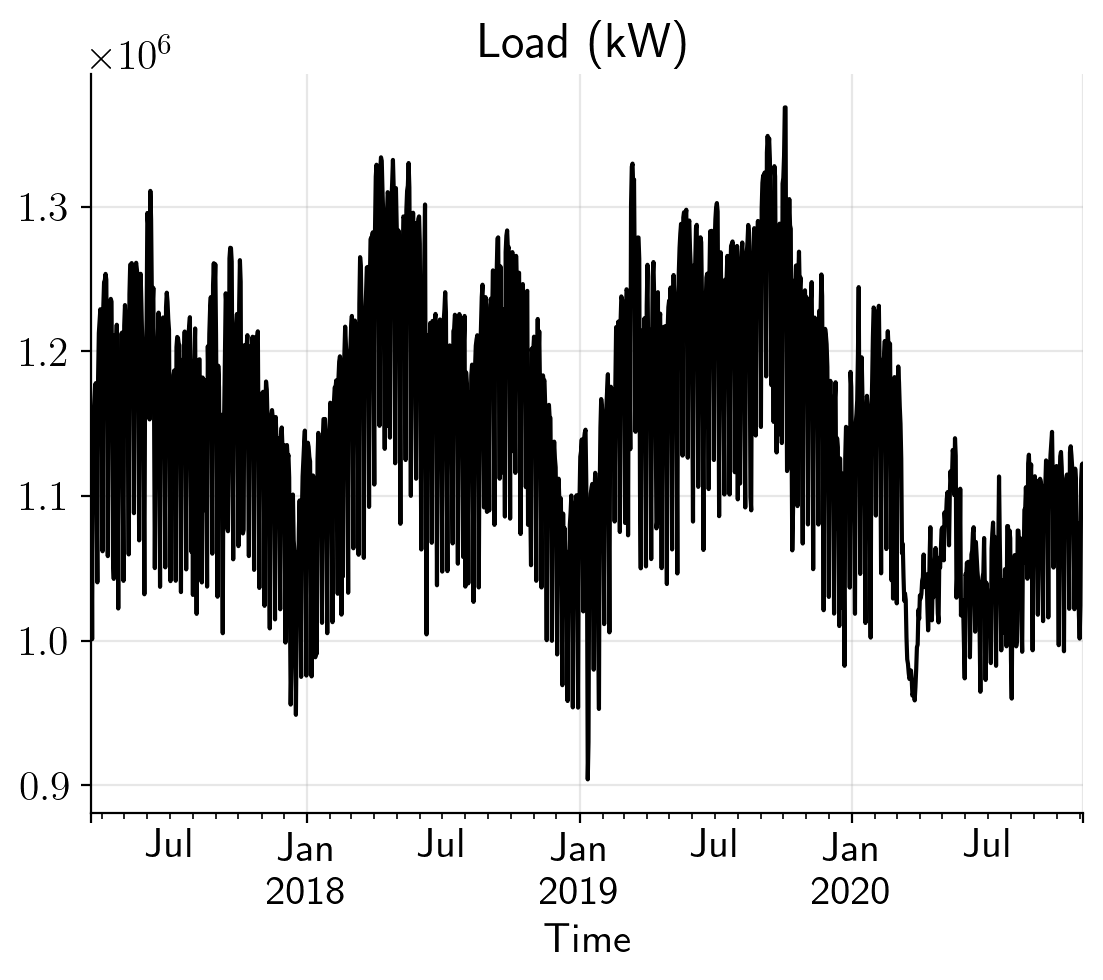

In [5]:
data.resample("D").mean()["Load (kW)"].plot(c="black")
plt.title("Load (kW)")
plt.grid(alpha=0.3)

## Preprocess data

In [6]:
target = "Load (kW)"

k_ahead = 1

y = data[target]#.diff()
series_mean = y.ewm(halflife=20).mean().shift(1)
series_std = y.ewm(halflife=20).std().shift(1)
y = (y - series_mean) / series_std

y = y.dropna()
index = y.index

y = jnp.array(y.shift(-k_ahead).values)[:-k_ahead]

X = data.loc[index].drop(target, axis=1)
X = X / X.ewm(span=20).std()

X = jnp.array(X)[:-k_ahead]

norm_periods = 100

vinit = np.nanvar(y[:norm_periods])
y = y[norm_periods:]
X = X[norm_periods:]
index = index[norm_periods:]

_, dim_features = X.shape

In [7]:
mae_baseline = np.abs(y - pd.Series(y).expanding().mean()).mean()
baseline_rolling = y - pd.Series(y).rolling(100).mean()

In [8]:
hist_collection = {"baseline": baseline_rolling}
mae_collection = {"baseline": mae_baseline}

## Base neural net

In [9]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(4)(x)
        x = nn.relu(x)
        x = nn.Dense(4)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [10]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

## C-ACI

In [11]:
method = "C-ACI"

In [12]:
def callback(bel, bel_prior, y, X, filter):
    # yhat = model.apply(bel_prior, X)
    yhat = filter.vobs_fn(bel_prior.mean, X)
    out = {
        "yhat": yhat,
        "err": y - yhat,
    }
    return out

In [13]:
def bo_select(logq):
    q = np.exp(logq)
    base_filter = ExtendedKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=q * jnp.eye(53),
        observation_covariance=1.0
    )
    bel_init = base_filter.init_bel(params_init)
    partc = partial(callback, filter=base_filter)
    _, hist = base_filter.scan(bel_init, y[:300, None], X[:300], partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -np.median(np.abs(hist["err"]))

In [14]:
boundaries = {
    "logq": [-20, 0]
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   logq    |
-------------------------------------
| 1         | -0.8875   | -18.19    |
| 2         | -0.8436   | -7.53     |
| 3         | -0.887    | -12.05    |
| 4         | -0.6765   | -3.323    |
| 5         | -0.6557   | -3.177    |
| 6         | -0.4861   | -2.067    |
| 7         | -0.2679   | -0.000959 |
| 8         | -0.2719   | -0.1085   |
| 9         | -0.268    | -0.003837 |
| 10        | -0.2678   | -0.000611 |
| 11        | -0.2678   | -0.000395 |
| 12        | -0.2678   | -0.000215 |
| 13        | -0.268    | -0.003023 |
| 14        | -0.2679   | -0.001178 |
| 15        | -0.2678   | -8.296e-0 |


In [15]:
base_filter = ExtendedKalmanFilter(
    lambda x: x, model.apply, dynamics_covariance=jnp.exp(0)* jnp.eye(53),
    observation_covariance=1.0
)

In [16]:
# bel_init = base_filter.init_bel(jnp.zeros(dim_features))
bel_init = base_filter.init_bel(params_init)
partc = partial(callback, filter=base_filter)
_, hist = base_filter.scan(bel_init, y, X, partc)

In [17]:
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.260881'

## RL-OUPR

In [18]:
def callback(bel, bel_prev, y, X, filter):
    eta = filter.filter.link_fn(bel_prev.mean, X).astype(float)
    mean = filter.filter.mean(eta)

    out = {
        "runlength": bel.runlength,
        "posterior": jnp.exp(bel.log_posterior),
        "yhat": mean,
        "err": mean - y,
    }
    return out


In [19]:
def bo_select(logq, logp, shock):
    q = np.exp(logq)
    p = np.exp(logp)
    
    base_filter = GaussianFilter(model.apply, dynamics_covariance=q, variance=1.0)
    filter = ExpfamRLOUPR(p, shock=shock, deflate_mean=False, filter=base_filter)
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_posterior_init=0.0)

    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)
    
    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [20]:
boundaries = {
    "logq": [-20, 0],
    "logp": [-20, 0],
    "shock": [0, 2.0],
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   logp    |   logq    |   shock   |
-------------------------------------------------------------
| 1         | -0.8579   | -18.19    | -7.53     | 0.7947    |
| 2         | -0.6478   | -3.323    | -3.177    | 0.4974    |
| 3         | -0.7748   | -15.76    | -4.145    | 1.812     |
| 4         | -0.8784   | -11.34    | -18.51    | 1.808     |
| 5         | -0.5377   | -2.228    | -5.637    | 1.024     |
| 6         | -0.884    | -0.135    | -9.338    | 0.3538    |
| 7         | -0.3788   | -1.508    | -4.424    | 1.926     |
| 8         | -0.884    | -0.1058   | -3.5      | 1.724     |
| 9         | -0.4288   | -1.972    | -4.834    | 1.799     |
| 10        | -0.4347   | -2.169    | -3.799    | 1.913     |
| 11        | -0.3475   | -1.072    | -6.094    | 1.956     |
| 12        | -0.884    | -0.1003   | -5.903    | 0.7835    |
| 13        | -0.4251   | -2.045    | -6.657    | 1.985     |
| 14        | -0.6831   | -4.254    | -7.19     | 1.755     |
| 15    

In [21]:
pmax = bo.max["params"]
q = np.exp(pmax["logq"])
p = np.exp(pmax["logp"])
shock = np.exp(pmax["shock"])

In [22]:
method = "RL-OUPR"

base_filter = GaussianFilter(model.apply, dynamics_covariance=q, variance=1.0)
filter = ExpfamRLOUPR(p, shock=shock, deflate_mean=False, filter=base_filter)

In [23]:
bel_init = filter.init_bel(params_init, cov=1.0, log_posterior_init=0.0)

partc = partial(callback, filter=filter)
_, hist = filter.scan(y[:, None], X, bel_init, partc)
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.199458'

In [26]:
rl_oupr_errs = {}

for p in tqdm(np.linspace(0, 0.99, 10)):
    base_filter = GaussianFilter(model.apply, dynamics_covariance=q, variance=1.0)
    filter = ExpfamRLOUPR(p, shock=shock, deflate_mean=False, filter=base_filter, threshold=1e-7)
    bel_init = filter.init_bel(params_init, cov=1.0, log_posterior_init=0.0)
    
    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:, None], X, bel_init, partc)
    rl_oupr_errs[p] = np.array(hist["err"]).squeeze()
rl_oupr_errs = pd.DataFrame(rl_oupr_errs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


<Axes: >

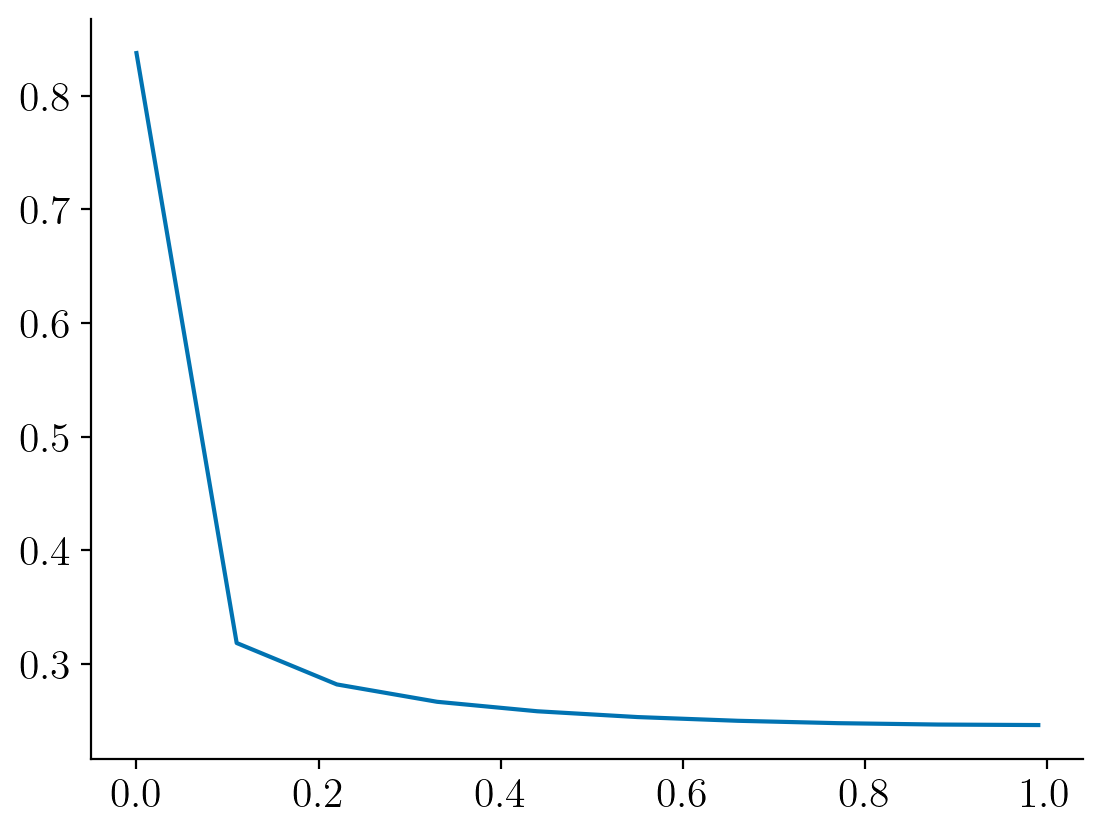

In [27]:
rl_oupr_errs.abs().mean(axis=0).plot()

## RL-PR

In [28]:
def callback(bel, bel_prev, y, X, ixs, filter):
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    eta = jax.vmap(filter.filter.link_fn, in_axes=(0, None))(bel_prev.mean, X).astype(float)
    mean = jax.vmap(filter.filter.mean)(eta)
    mean = jnp.einsum("k,km->m", posterior, mean)
    
    out = {
        "runlength": bel.runlength,
        # "ixs": ixs,
        "posterior": posterior,
        "yhat": mean,
        "err": mean - y,
    }
    return out


In [29]:
def bo_select(logp):
    p = np.exp(logp)

    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamRLPR(p, K=1, filter=base_filter)
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [30]:
boundaries = {
    "logp": [-20, 0.0],
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   logp    |
-------------------------------------
| 1         | -0.8868   | -18.19    |
| 2         | -0.8868   | -7.53     |
| 3         | -0.8868   | -12.05    |
| 4         | -0.8868   | -3.323    |
| 5         | -0.8868   | -3.177    |
| 6         | -0.8868   | -19.99    |
| 7         | -0.884    | -0.000959 |
| 8         | -0.5217   | -0.7145   |
| 9         | -0.6521   | -0.964    |
| 10        | -0.884    | -0.5135   |
| 11        | -0.8868   | -10.3     |
| 12        | -0.5807   | -0.8092   |
| 13        | -0.831    | -1.156    |
| 14        | -0.884    | -0.6668   |
| 15        | -0.5217   | -0.7145   |


In [31]:
pmax = bo.max["params"]
p = np.exp(pmax["logp"])

In [32]:
method = "RL-PR"
base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
filter = ExpfamRLPR(p, K=1, filter=base_filter)
_, n_feats = X.shape

bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

partc = partial(callback, filter=filter)
_, hist_rlpr = filter.scan(y[:, None], X, bel_init, partc)
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist_rlpr["err"]

format(np.median(np.abs(hist_rlpr["err"])), ",.6f")

'0.463115'

## Multiple values of $\pi$

In [33]:
rlpr_errs = {}
for p in tqdm(np.linspace(0, 1, 10)):
    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamRLPR(p, K=3, filter=base_filter)
    _, n_feats = X.shape
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)
    
    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:, None], X, bel_init, partc)
    mae = np.abs(hist["err"]).mean()
    
    rlpr_errs[p] = hist["err"].squeeze()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


In [34]:
rlpr_errs = pd.DataFrame(rlpr_errs)

<Axes: >

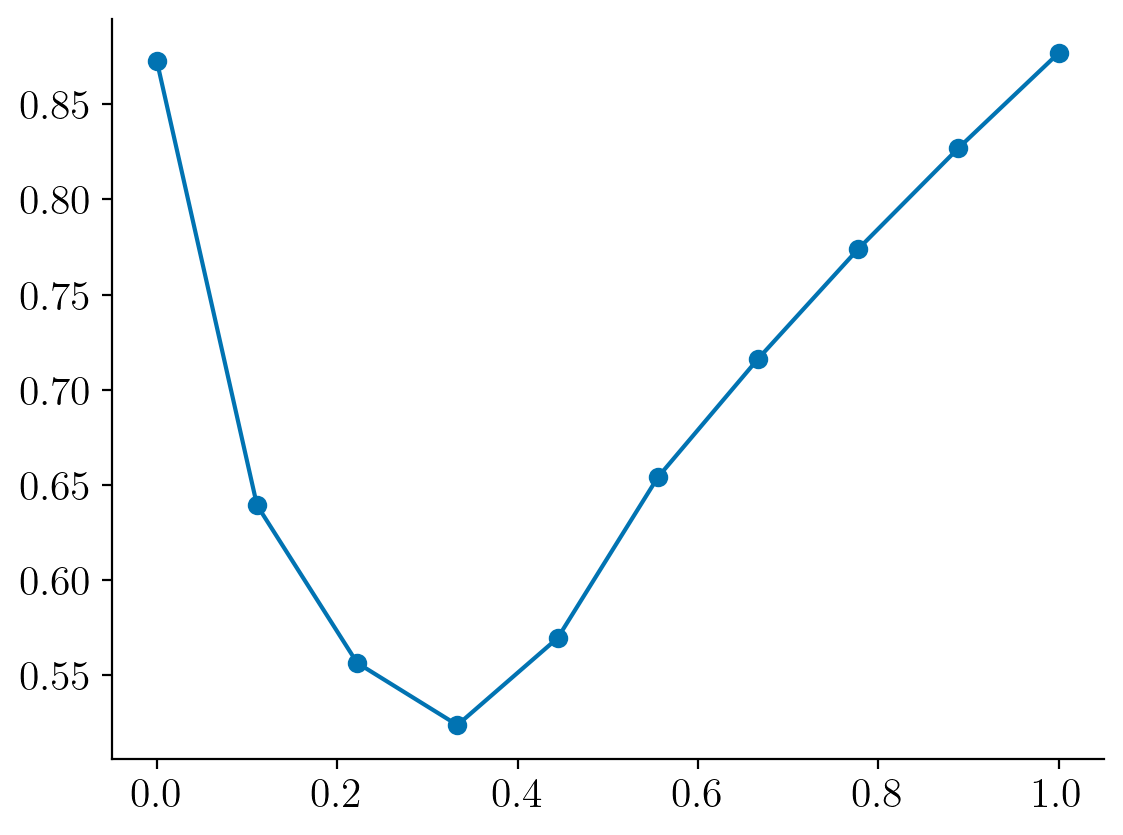

In [35]:
rlpr_errs.abs().mean(axis=0).plot(marker="o")

## CPP-OU

In [36]:
def callback(bel, bel_prev, y, X, filter):
    eta = filter.filter.link_fn(bel_prev.mean, X)
    mean = filter.filter.mean(eta)
    
    out = {
        "yhat": mean,
        "err": mean - y,
        "eta": bel.eta
    }
    return out

In [37]:
def bo_select(log_drift, log_lr):
    drift = np.exp(log_drift)
    lr = np.exp(log_lr)
    
    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamEBA(
        n_inner=3, ebayes_lr=lr, state_drift=drift, filter=base_filter,
        deflate_mean=True, deflate_covariance=True
    )
    
    bel_init = filter.init_bel(params_init, cov=1.0)
    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [38]:
boundaries = {
    "log_drift": [-20, 1.0],
    "log_lr": [-20, 0.0],
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | log_drift |  log_lr   |
-------------------------------------------------
| 1         | -0.8878   | -18.1     | -7.53     |
| 2         | -0.8817   | -11.66    | -3.323    |
| 3         | -0.8868   | -2.336    | -15.03    |
| 4         | -0.8825   | -15.55    | -4.145    |
| 5         | -0.8778   | -0.976    | -11.34    |
| 6         | -0.8868   | -5.67     | -17.88    |
| 7         | -0.8875   | -14.76    | -8.713    |
| 8         | -0.8604   | -0.05112  | -10.7     |
| 9         | -0.8596   | -0.2609   | -10.28    |
| 10        | -0.8351   | 0.7661    | -9.847    |
| 11        | -0.7892   | 0.961     | -8.364    |
| 12        | -0.764    | 0.9281    | -6.864    |
| 13        | -0.6539   | 0.986     | -3.585    |
| 14        | -0.6222   | 0.9603    | -0.454    |
| 15        | -0.7439   | -2.196    | -0.511    |


In [39]:
pmax = bo.max["params"]
drift = np.exp(pmax["log_drift"])
lr = np.exp(pmax["log_lr"])

In [40]:
method = "CPP-OU"

base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
filter = ExpfamEBA(
    n_inner=3, ebayes_lr=lr, state_drift=drift, filter=base_filter,
    deflate_mean=True, deflate_covariance=True
)

bel_init = filter.init_bel(params_init, cov=1.0)

In [41]:
partc = partial(callback, filter=filter)
_, hist = filter.scan(y[:, None], X, bel_init, partc)
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.607800'

In [42]:
cpp_ou = {}

for v in tqdm(np.linspace(0, 1, 10)):
    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamEBA(
        n_inner=3, ebayes_lr=lr, state_drift=v, filter=base_filter,
        deflate_mean=True, deflate_covariance=True
    )
    
    bel_init = filter.init_bel(params_init, cov=1.0)
    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:, None], X, bel_init, partc)
    cpp_ou[v] = hist["err"].ravel()

cpp_ou = pd.DataFrame(cpp_ou)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]


<Axes: >

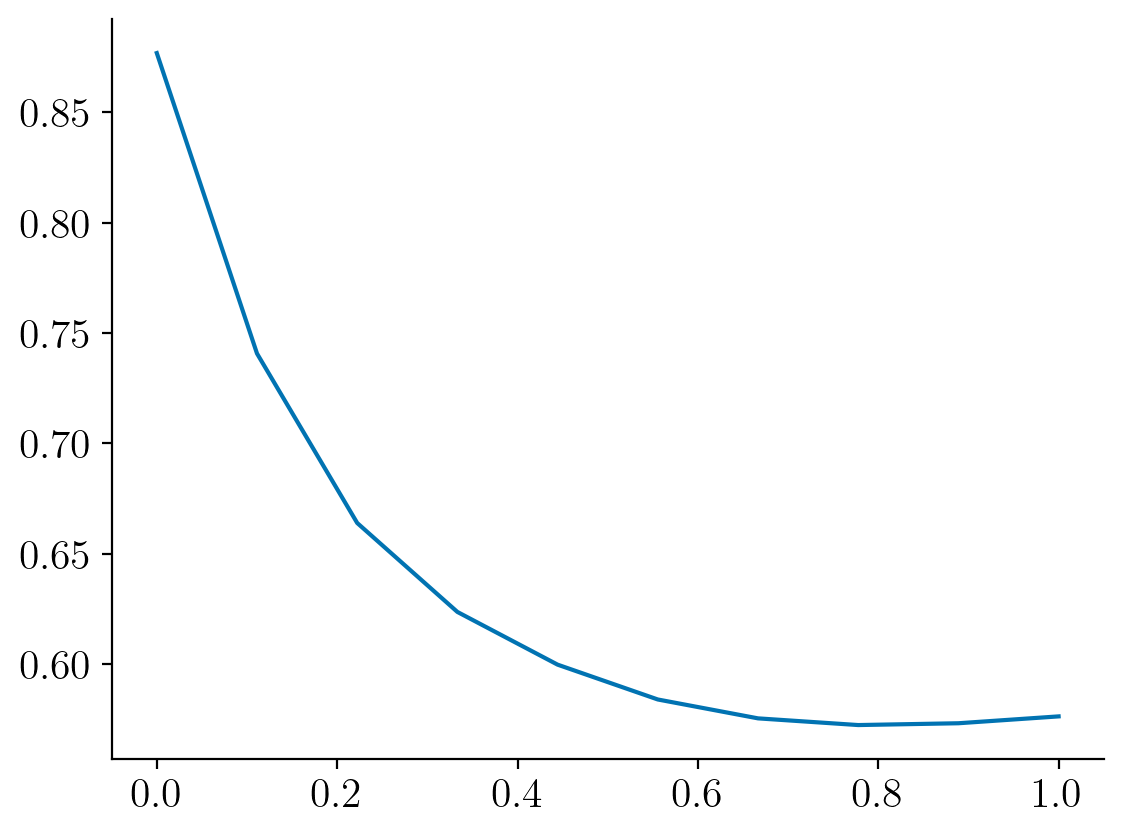

In [43]:
cpp_ou.abs().mean(axis=0).plot()

---

# Plots

In [47]:
errs_df = pd.DataFrame({
    method: np.array(hist_collection[method]).ravel()
    for method in hist_collection
}, index=index[1:])
errs_df = errs_df.sort_index(axis=1)
errs_df = errs_df.rename({"RL-OUPR":"RL-OUPR*"}, axis=1)

groupper = [f"{y}/{m:02}" for y, m in zip(errs_df.index.year.values, errs_df.index.month.values)]

In [49]:
methods = [m for m in errs_df.columns if m != "baseline"]

yhat = errs_df + np.array(y)[:, None]
yhat = yhat * series_std[index].iloc[1:].values[:, None] + series_mean[index].iloc[1:].values[:, None]

In [50]:
y_raw = np.array(y)
y_true = y_raw[:, None] * series_std[index].iloc[1:].values[:, None] + series_mean[index].iloc[1:].values[:, None]
y_true = pd.Series(y_true.ravel(), index=yhat.index)
y_raw = pd.Series(y_raw, index=yhat.index)

In [51]:
abs_err_df = np.abs(errs_df.div(y_raw, axis=0))
abs_err_df["groupper"] = groupper

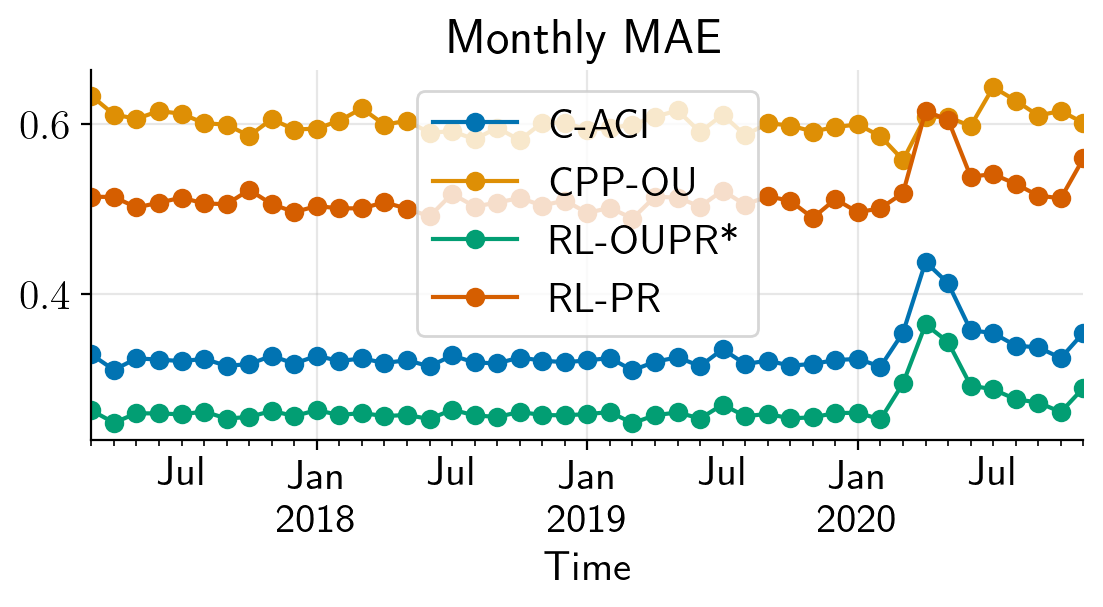

In [52]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))

errs_df.drop("baseline", axis=1).abs().resample("ME").mean().plot(marker="o", ax=ax)
plt.title("Monthly MAE")

plt.grid(alpha=0.3)
plt.savefig(f"../figures/day-ahead-mae.png", dpi=300, bbox_inches="tight")

## Tracking

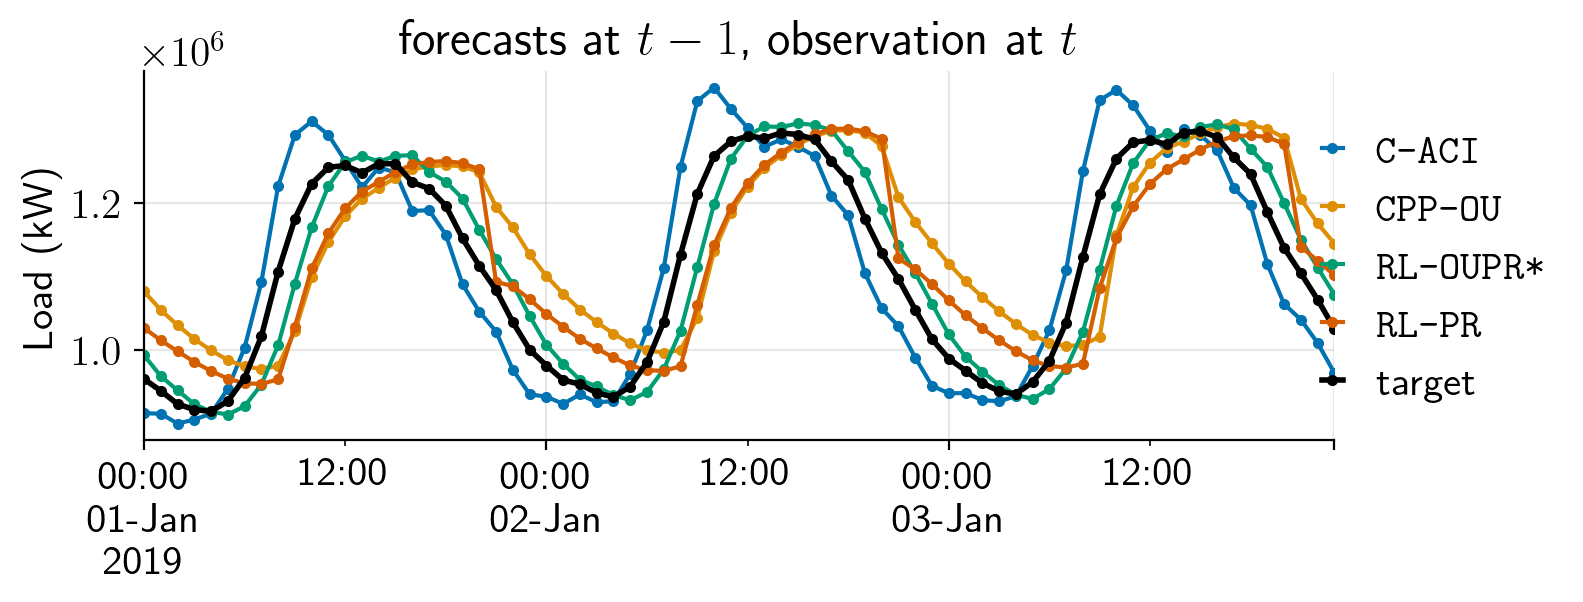

In [53]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

time_slice = slice("2019-01-01", "2019-01-03")

for method in methods:
    label = r"\texttt{" + method + "}"
    yhat[method][time_slice].plot(marker="o", markersize=3, label=label)

y_true[time_slice].plot(label="target", c="black", marker="o", markersize=3, linewidth=2)
plt.title("forecasts at $t-1$, observation at $t$")
plt.ylabel(target)
plt.xlabel("")
plt.legend(loc="lower right", bbox_to_anchor=(1.21, 0), frameon=False, handlelength=0.5)
plt.grid(alpha=0.3)
plt.savefig(f"../figures/day-ahead-forecast.png", dpi=300, bbox_inches="tight")

## Plot over periods

In [54]:
date_init = datetime(2020, 3, 4)
date_end = datetime(2020, 3, 10)

# date_init = datetime(2020, 3,8)
# date_end = datetime(2020, 3, 9)

daterange = slice(date_init, date_end)
err_range = errs_df.drop("baseline", axis=1).abs().rolling("12h").mean()[daterange]
err_range.columns = [r"\texttt{" + c.replace("RL", "RL[1]") + "}" for c in err_range.columns]

# Regimes
reg_change = datetime(2020, 3, 7, 0)
reg_init = datetime(2020, 3, 7, 0)
reg_end = datetime(2020, 3, 8, 20)

In [55]:
import matplotlib.dates as mdates

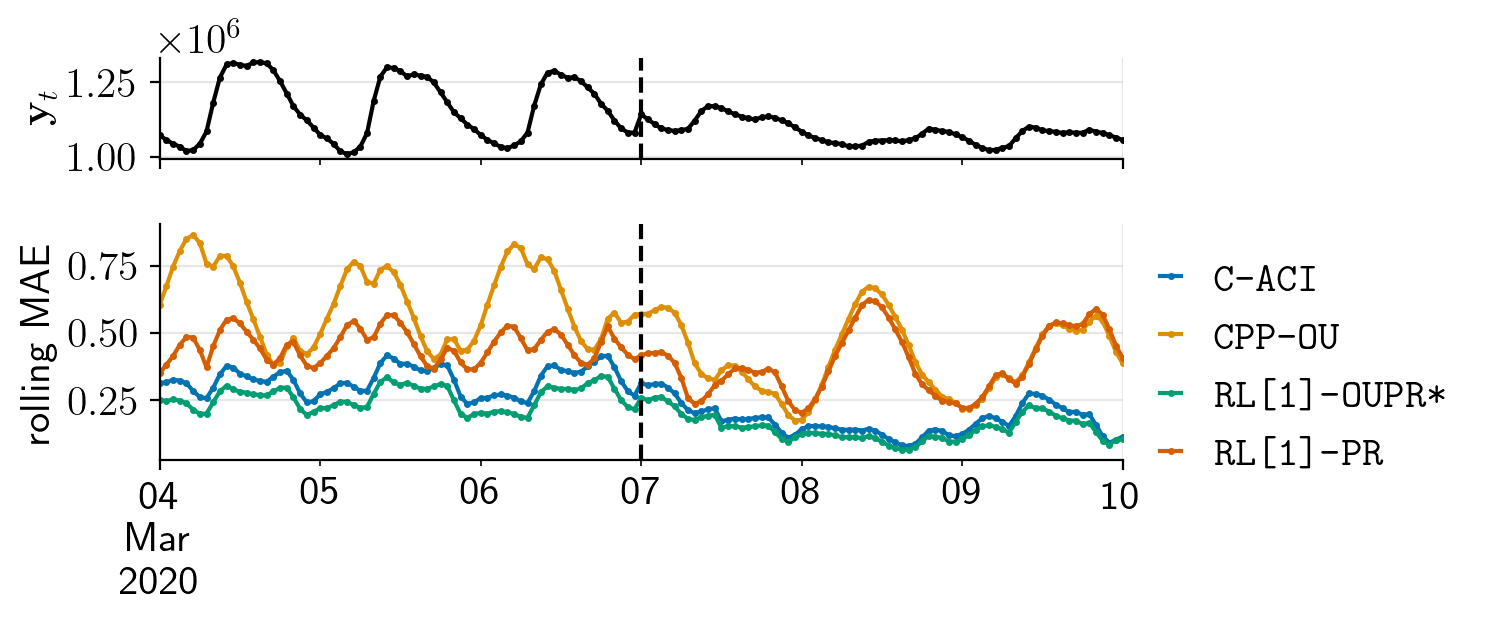

In [56]:
fig = plt.figure(figsize=(6.4 * 1.2, 4.8 * 0.7))
gs = GridSpec(2, 1, height_ratios=(0.3, 0.7))

ax2 = fig.add_subplot(gs[0], sharex=ax)
y_true[daterange].plot(marker="o", markersize=1.5, ax=ax2, c="black")

ax = fig.add_subplot(gs[1])
err_range.plot(ax=ax, marker="o", markersize=1.5)
ax.legend(ncol=1, handlelength=0.5, frameon=False, bbox_to_anchor=(1,1.0))

for axi in [ax, ax2]:
    axi.grid(alpha=0.3)
    axi.axvline(x=reg_change, c="black", linestyle="dashed")

# ax.tick_params(labelbottom=False)
plt.tight_layout()
ax2.set_ylabel(r"${\bf y}_t$")
ax.set_ylabel(r"rolling MAE")
ax.set_xlabel("")
ax2.set_xlabel("")

plt.tight_layout()

plt.savefig("../figures/day-ahead-abrupt-drift-comparison.png", dpi=300, bbox_inches="tight")

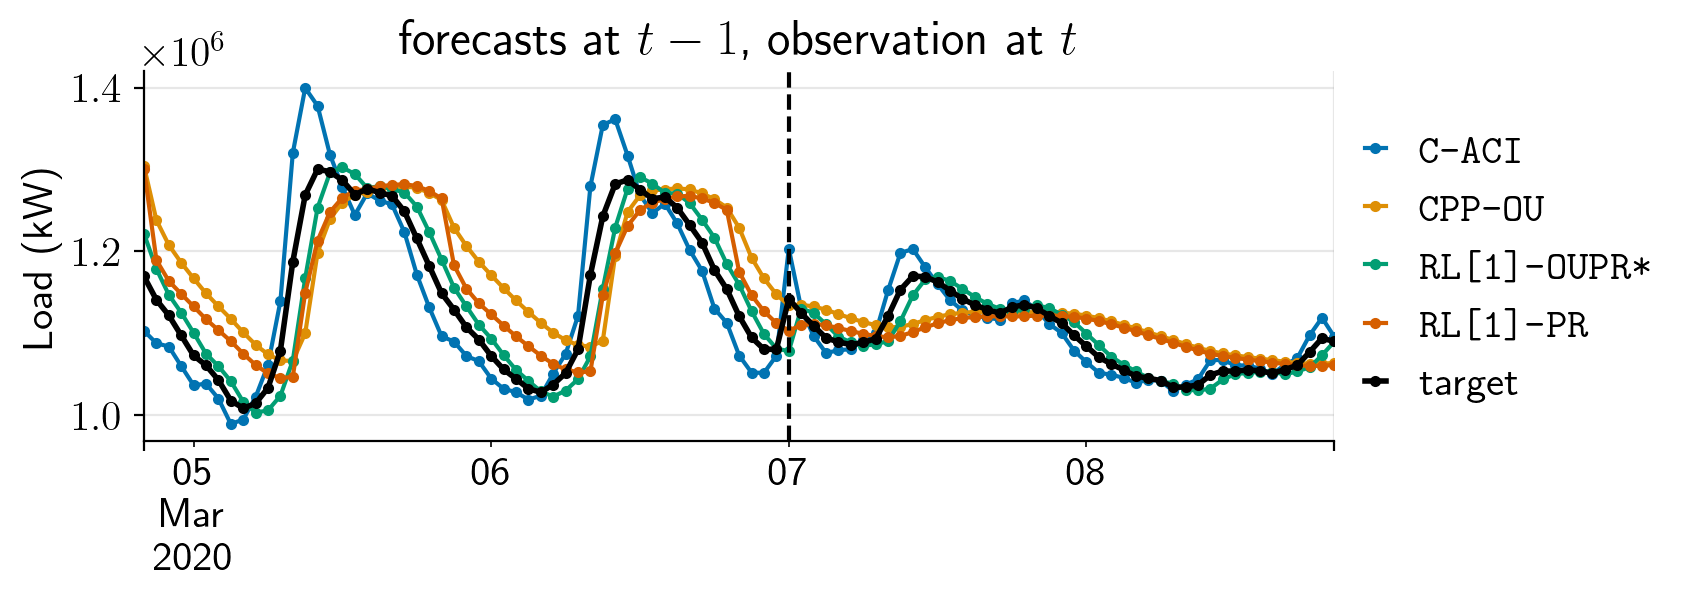

In [57]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

reg_init = datetime(2020, 3, 4, 20)
reg_end = datetime(2020, 3, 8, 20)

daterange = slice(reg_init, reg_end)


for method in methods:
    label = r"\texttt{" + method.replace("RL", "RL[1]") + "}"
    yhat[method][daterange].plot(marker="o", markersize=3, label=label)

ax.axvline(x=reg_change, c="black", linestyle="dashed")

y_true[daterange].plot(label="target", c="black", marker="o", markersize=3, linewidth=2)
plt.title("forecasts at $t-1$, observation at $t$")
plt.ylabel(target)
plt.xlabel("")
plt.legend(loc="lower right", bbox_to_anchor=(1.3, 0), frameon=False, handlelength=0.5)
plt.grid(alpha=0.3)
plt.savefig(f"../figures/day-ahead-forecast.png", dpi=300, bbox_inches="tight")

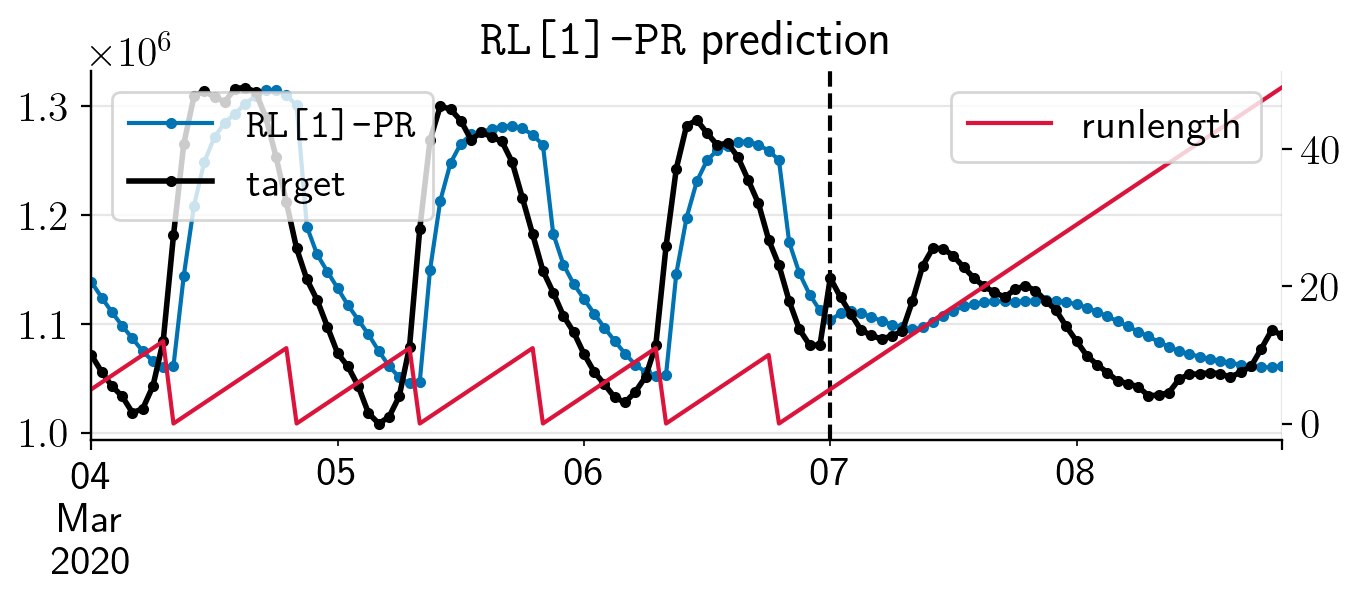

In [58]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))
ax2 = ax.twinx()

daterange = slice(date_init, reg_end)


yhat["RL-PR"][daterange].plot(label=r"\texttt{RL[1]-PR}", marker="o", markersize=3, ax=ax)
y_true[daterange].plot(label="target", c="black", marker="o", markersize=3, linewidth=2,ax=ax)

(
    pd.Series(np.array(hist_rlpr["runlength"]).ravel(), index=y_raw.index)[daterange]
      .plot(ax=ax2, c="crimson", label="runlength")
)
ax.axvline(x=reg_change, c="black", linestyle="dashed")

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title(r"\texttt{RL[1]-PR} prediction")
ax.grid(alpha=0.3)
ax.set_xlabel("")
# plt.tight_layout()
plt.savefig(f"../figures/day-ahead-forecast-rlpr.png", dpi=300, bbox_inches="tight")

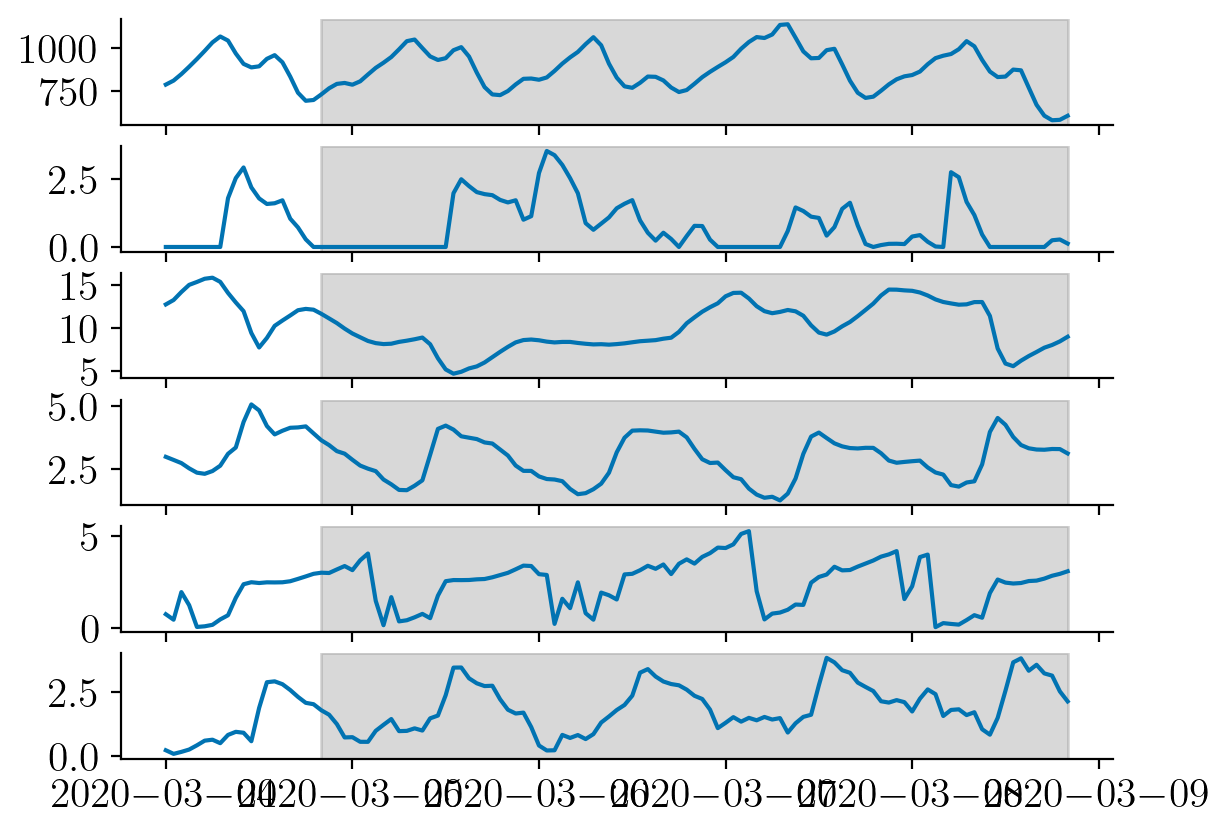

In [59]:
fig, axs = plt.subplots(6, 1, sharex=True)

features = pd.DataFrame(np.array(X), index=y_raw.index)
for ax, col in zip(axs, features):
    ax.plot(features.loc[daterange, col])
    ax.axvspan(reg_init, reg_end, alpha=0.3, color='tab:gray')

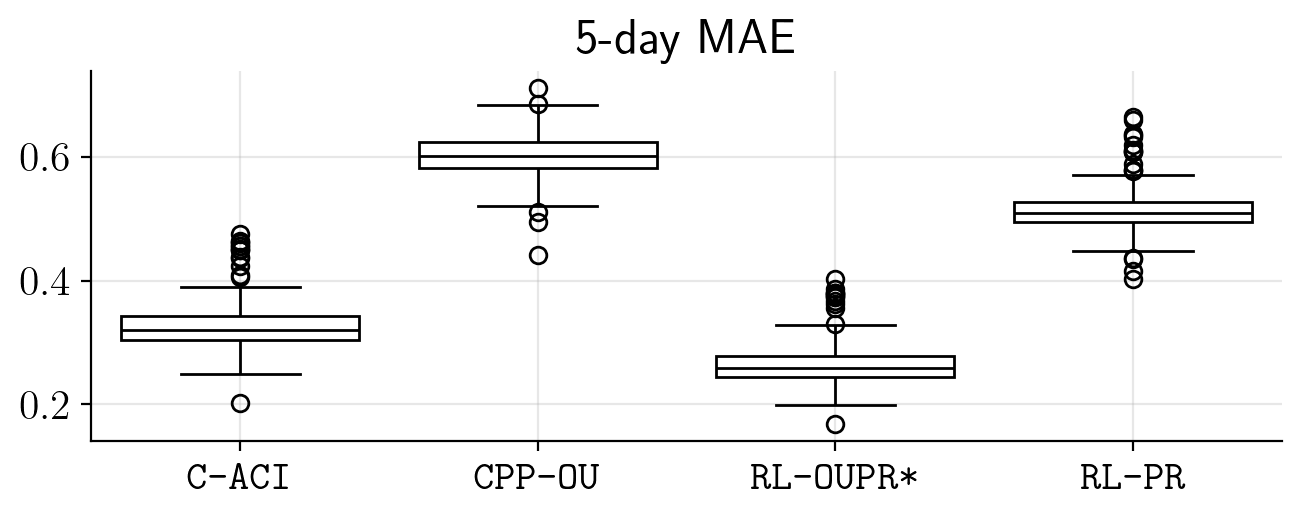

In [60]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

plt.title("5-day MAE")
sns.boxplot(
    x="variable",
    y="value",
    data=errs_df.drop("baseline", axis=1).abs().resample("5D").mean().melt(),
    color="white",
    linecolor="black"
)

# ticks = plt.gca().get_xticklabels()
pos, ticks = plt.xticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.xticks(pos, newlabels)

plt.xlabel("")
plt.ylabel("")
plt.grid(alpha=0.3)
plt.savefig("../figures/day-ahead-results.png", dpi=300, bbox_inches="tight")

## RL-PR with varying hypothesis

In [61]:
def callback(bel, bel_prev, y, X, ixs, filter):
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    eta = jax.vmap(filter.filter.link_fn, in_axes=(0, None))(bel_prev.mean, X).astype(float)
    mean = jax.vmap(filter.filter.mean)(eta)
    mean = jnp.einsum("k,km->m", posterior, mean)
    
    out = {
        "runlenght": bel.runlength,
        # "ixs": ixs,
        "posterior": posterior,
        "yhat": mean,
        "err": mean - y,
    }
    return out


In [62]:
def bo_select(logp, K):
    p = np.exp(logp)

    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamRLPR(p, K=K, filter=base_filter)
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [63]:
hist_collection_rlpr = {}

In [64]:
boundaries = {
    "logp": [-20, 0.0],
}

for K in [1, 2, 5, 10, 15]:
    bo = BayesianOptimization(
        partial(bo_select, K=K), boundaries, random_state=3141, allow_duplicate_points=True,
        verbose=1,
    )
    bo.maximize(init_points=5, n_iter=10)

    pmax = bo.max["params"]
    p = np.exp(pmax["logp"])
    
    method = K
    
    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamRLPR(p, K=3, filter=base_filter)
    _, n_feats = X.shape
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)
    
    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:, None], X, bel_init, partc)
    mae = np.abs(hist["err"]).mean()
    
    hist_collection_rlpr[method] = hist["err"]
    
    print(K, format(np.median(np.abs(hist["err"])), ",.6f"))

|   iter    |  target   |   logp    |
-------------------------------------
| 7         | -0.884    | -0.000959 |
| 8         | -0.5217   | -0.7145   |
1 0.612476
|   iter    |  target   |   logp    |
-------------------------------------
| 2         | -0.885    | -7.53     |
| 4         | -0.7257   | -3.323    |
| 5         | -0.7184   | -3.177    |
| 7         | -0.6581   | -2.007    |
| 10        | -0.6077   | -1.469    |
| 13        | -0.5421   | -1.094    |
2 0.483232
|   iter    |  target   |   logp    |
-------------------------------------
| 2         | -0.8833   | -7.53     |
| 4         | -0.6891   | -3.323    |
| 5         | -0.6814   | -3.177    |
| 7         | -0.5902   | -2.001    |
| 10        | -0.5361   | -1.441    |
| 13        | -0.5158   | -1.104    |
5 0.486155
|   iter    |  target   |   logp    |
-------------------------------------
| 2         | -0.8683   | -7.53     |
| 4         | -0.6729   | -3.323    |
| 5         | -0.6659   | -3.177    |
| 7         | -0.

In [65]:
errs_rlpr_df = pd.DataFrame({
    method: np.array(hist_collection_rlpr[method]).ravel()
    for method in hist_collection_rlpr
}, index=index[1:])
errs_rlpr_df = errs_rlpr_df.sort_index(axis=1)

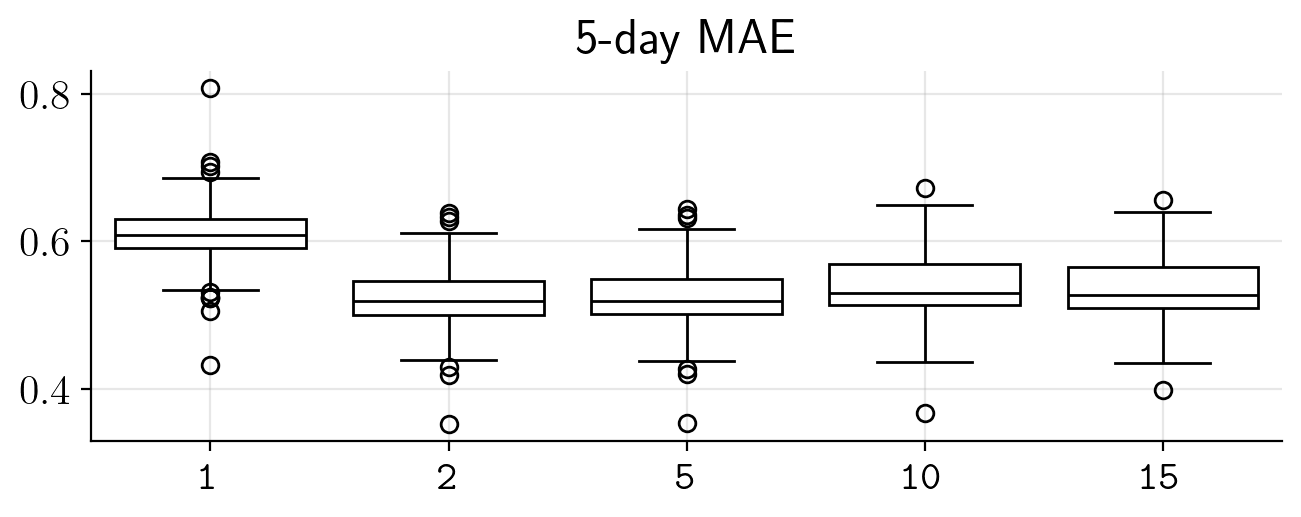

In [66]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

plt.title("5-day MAE")
sns.boxplot(
    x="variable",
    y="value",
    data=errs_rlpr_df.abs().resample("5D").mean().melt(),
    color="white",
    linecolor="black"
)

# ticks = plt.gca().get_xticklabels()
pos, ticks = plt.xticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.xticks(pos, newlabels)

plt.xlabel("")
plt.ylabel("")
plt.grid(alpha=0.3)